# Quantum Multiplication

In [1]:
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
%pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute

In [3]:
# multi-qubit Toffoli: applies a flip (NOT gate) to the target if all controls are 1
def multiFlip(qc, q_controls, q_target):
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    qc.h(q_target)
    multiPhase(qc, q_controls+[q_target], np.pi)
    qc.h(q_target)

# multi-qubit controlled phase: applies a phase factor exp(i*pi*theta) if all the qubits are 1.
# Note that it doesn't matter which qubits are the controls and which is the target.
def multiPhase(qc, q, theta):
    # qc is a quantum circuit
    # q is a quantum register in qc
    # theta is a float
    if len(q) == 1:
        qc.p(theta, q[0])
    elif len(q) == 2:
        qc.cp(theta, q[0], q[1])
    else:
        qc.cp(theta/2, q[1], q[0])
        multiFlip(qc, q[2:], q[1])
        qc.cp(-theta/2, q[1], q[0])
        multiFlip(qc, q[2:], q[1])
        multiPhase(qc, [q[0]]+q[2:], theta/2)

In [4]:
def qft(qc, q):

    n = len(q)

    for j in range(n-1, -1, -1):
        qc.h(q[j])
        for k in range(j-1, -1, -1):
            qc.cp(2*np.pi*2**(-(j-k+1)), q[k], q[j])

    for l in range(int(np.floor(n/2))):
        qc.swap(q[l], q[n-1-l])

In [5]:
def iqft(qc, q):

    n = len(q)

    for l in range(int(np.floor(n/2))):
        qc.swap(q[l], q[n-1-l])

    for j in range(n):
        for k in range(j):
            qc.cp(-2*np.pi*2**(-(j-k+1)), q[k], q[j])
        qc.h(q[j])

In [6]:
def makeIntegerCircuit(n, x, m=0, y=None, p=0, z=None, nocbits=False):

    # define base quantum and classical registers
    q = qiskit.QuantumRegister(n+m+p)
    if nocbits:
        c = qiskit.ClassicalRegister(1)
    else:
        c = qiskit.ClassicalRegister(n+m+p)
    qc = qiskit.QuantumCircuit(q, c)

    # turn base quantum registers into separate lists
    if (y is None) and (z is None):
        qx = [q[i] for i in range(n)]
    elif (z is None):
        qy = [q[i] for i in range(m)]
        qx = [q[i] for i in range(m,m+n)]
    else:
        qz = [q[i] for i in range(p)]
        qy = [q[i] for i in range(p,p+m)]
        qx = [q[i] for i in range(p+m,p+m+n)]

    # encode integers into quantum registers
    bits = np.binary_repr(x, width=n)
    for i in range(n):
        if bits[n-1-i] == '1':
            qc.x(qx[i])
    if y is not None:
        bits = np.binary_repr(y, width=m)
        for i in range(m):
            if bits[m-1-i] == '1':
                qc.x(qy[i])
    if z is not None:
        bits = np.binary_repr(z, width=p)
        for i in range(p):
            if bits[p-1-i] == '1':
                qc.x(qz[i])

    # return final circuit and registers
    if (y is None) and (z is None):
        return qc, c, qx
    elif (z is None):
        return qc, c, qx, qy
    else:
        return qc, c, qx, qy, qz

In [7]:
def measureCircuit(qc, c, qx, qy=None, qz=None):

    # determine number of qubits in each register
    n = len(qx)
    if qy is not None:
        m = len(qy)
    else:
        m = 0
    if qz is not None:
        p = len(qz)
    else:
        p = 0

    # apply measurement gates
    if (qy is None) and (qz is None):
        for i in range(n):
            qc.measure(qx[i], c[i])
    elif (qz is None):
        for j in range(m):
            qc.measure(qy[j], c[j])
        for i in range(n):
            qc.measure(qx[i], c[m+i])
    else:
        for k in range(p):
            qc.measure(qz[k], c[k])
        for j in range(m):
            qc.measure(qy[j], c[p+j])
        for i in range(n):
            qc.measure(qx[i], c[p+m+i])

    # execute quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024)
    result = job.result()
    data = result.get_counts(qc)

    # extract the integer values of the input register, x, and output register, y
    out = list(data.keys())[0]
    z = 0
    for k in range(p):
        if out[n+m+p-1-k] == '1':
            z += 2**k
    y = 0
    for j in range(p,p+m):
        if out[n+m+p-1-j] == '1':
            y += 2**(j-p)
    x = 0
    for i in range(p+m,p+m+n):
        if out[n+m+p-1-i] == '1':
            x += 2**(i-m-p)

    if (qy is None) and (qz is None):
        return x
    elif (qz is None):
        return x, y
    else:
        return x, y, z

In [8]:
def mult(qc, qx, qy, qa):
    # qc is a quantum circuit consisting of three quantum registers: qx, qy, qa

    # qx is the input register for the multiplier
    n = len(qx) - 1

    # qy is the input register for the multiplicand
    m = len(qy) - 1

    # qa is the output register
    p = len(qa) - 1

    # Put your code here.


    qft(qc, qa)
    qc.barrier()
###
    for i in range(0, n+1):
      for j in range(0, m+1):
        for k in range(0, p+1):
          if (len(qa))-k-j-i >= 1:
            qc.mcp(2*np.pi / (2**((len(qa))-k-j-i)), [qx[i], qy[j]], qa[k])
###
    qc.barrier()
    iqft(qc, qa)
###


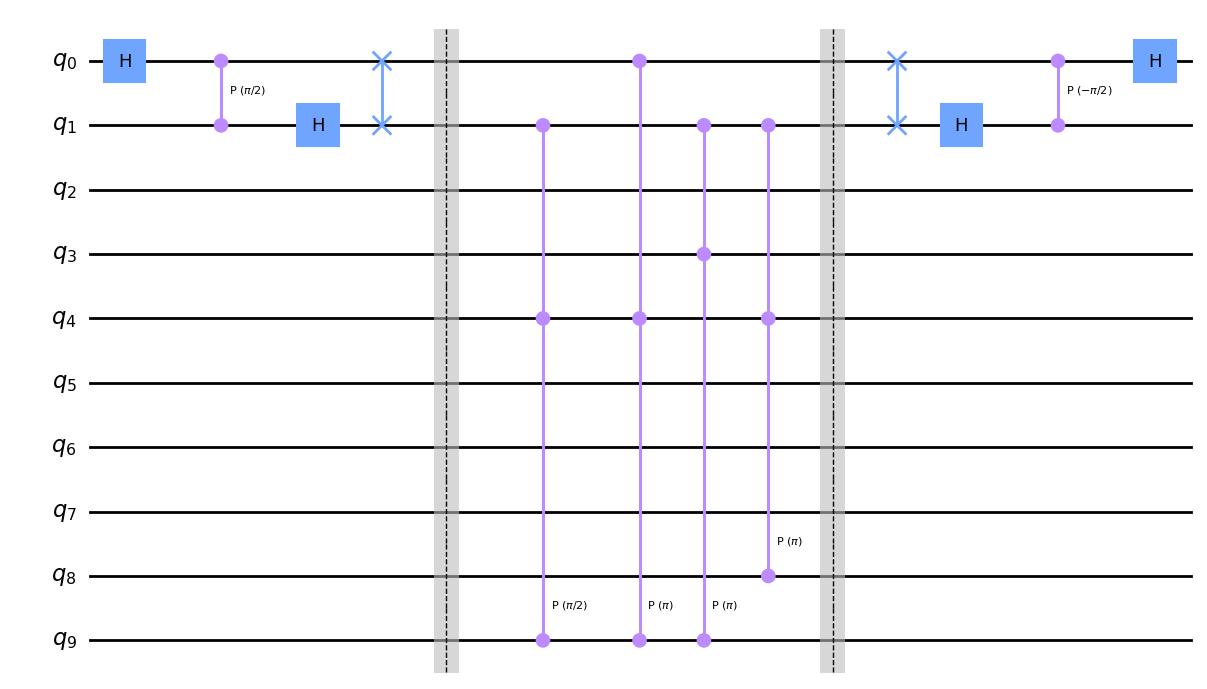

In [9]:
bob = QuantumCircuit(10)
mult(bob, [9,8,7,6,5],[4,3,2],[1,0])
bob.draw('mpl')

In [11]:
def test(fun):

    # pick a random multiplier and multiplicand
    n = np.random.randint(1,4)
    m = np.random.randint(1,4)
    p = int(np.floor(np.log2(1+(2**n-1)*(2**m-1))))
    print("n = "+str(n) + ", m = "+str(m) + ", p = "+str(p))
    x = np.random.randint(2**n)
    y = np.random.randint(2**m)
    a = np.random.randint(2**p)
    print("x = "+str(x) + ", y = "+str(y) + ", a = "+str(a))

    # apply the algorithm
    qc, c, qx, qy, qz = makeIntegerCircuit(n, x, m, y, p, a)
    fun(qc, qx, qy, qz)
    x_out, y_out, z_out = measureCircuit(qc, c, qx, qy, qz)

    # should be the same
    print("|"+str(x)+">"     + "|"+str(y)+">"     + "|"+str((a+x*y) % 2**p)+">")
    print("|"+str(x_out)+">" + "|"+str(y_out)+">" + "|"+str(z_out)+">")

test(mult)
print()
test(mult)
print()
test(mult)
print()
test(mult)
print()
test(mult)
print()

n = 2, m = 3, p = 4
x = 2, y = 4, a = 15
|2>|4>|7>
|2>|4>|7>

n = 2, m = 3, p = 4
x = 1, y = 5, a = 1
|1>|5>|6>
|1>|5>|6>

n = 3, m = 1, p = 3
x = 0, y = 1, a = 0
|0>|1>|0>
|0>|1>|0>

n = 3, m = 1, p = 3
x = 6, y = 1, a = 4
|6>|1>|2>
|6>|1>|2>

n = 1, m = 1, p = 1
x = 1, y = 1, a = 0
|1>|1>|1>
|1>|1>|1>

